In [1]:
import glob
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # for scikit-learn >= 0.18 use:
from scipy.ndimage.measurements import label

#import matplotlib.image as mpimg
%matplotlib inline

## 1. Explore Dataset
So far I know there are two classes of images, vehicles and non-vehicles

In [2]:
basedir = './trainingdata'
#basedir = 'C:\\Users\\bauerge\\Google Drive\\trainingdata'
img_types = os.listdir(basedir)
#print(img_types)

In [3]:
cars=[]
notcars=[]

images = glob.glob(basedir + '/**/**/*.png')
print(images[0])

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

print('Number of car images: ' + str(len(cars)))
print('Number of not-car images: ' + str(len(notcars)))

./trainingdata\non-vehicles\Extras\extra1.png
Number of car images: 8792
Number of not-car images: 8968


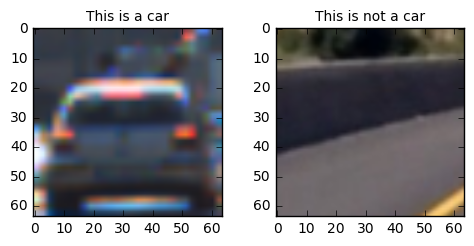

In [4]:
idx_cars = np.random.randint(0, len(cars))
img_car = cv2.cvtColor(cv2.imread(cars[idx_cars]), cv2.COLOR_BGR2RGB)

idx_notcars = np.random.randint(0, len(notcars))
img_notcar = cv2.cvtColor(cv2.imread(notcars[idx_notcars]), cv2.COLOR_BGR2RGB)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 10))
f.tight_layout()
ax1.imshow(img_car)
ax1.set_title('This is a car', fontsize=10)

ax2.imshow(img_notcar)
ax2.set_title('This is not a car', fontsize=10)

## 2. Visualize and compare histograms of different colorspaces

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False, title=None):
    '''
    A function to compute color histogram features 
    '''    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if (visualize==True):
        # Plot the result
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
        f.tight_layout()
        
        ax1.plot(channel1_hist[0])
        ax1.set_title(title+' Ch1', fontsize=50)

        #ax2.imshow(channel2_hist)
        ax2.plot(channel2_hist[0])
        ax2.set_title(title+' Ch2', fontsize=50)

        #ax3.imshow(channel3_hist)
        ax3.plot(channel3_hist[0])
        ax3.set_title(title+' Ch3', fontsize=50)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

array([121,  73, 252, 224,  77,  22,  35,  29,  15,   6,  11,   5,  34,
        75, 229, 831, 292,  93, 144,  90, 453, 824, 161,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  45, 780, 950, 261, 140, 159, 200,
       322, 378, 248, 165, 145,  69,  31,  24,  27,  44,  22,  10,   9,
         3,   4,   2,   4,   2,   7,   2,   5,   3,  17,   0,  18,   0,
        97,  71,  49,  72, 456, 766, 161, 137,  72,  74, 102, 177, 694,
       950,  99,  27,  17,  12,   6,   1,   5,   4,   1,   4,   3,   3,
         6,   4,   6,  12,   8], dtype=int64)

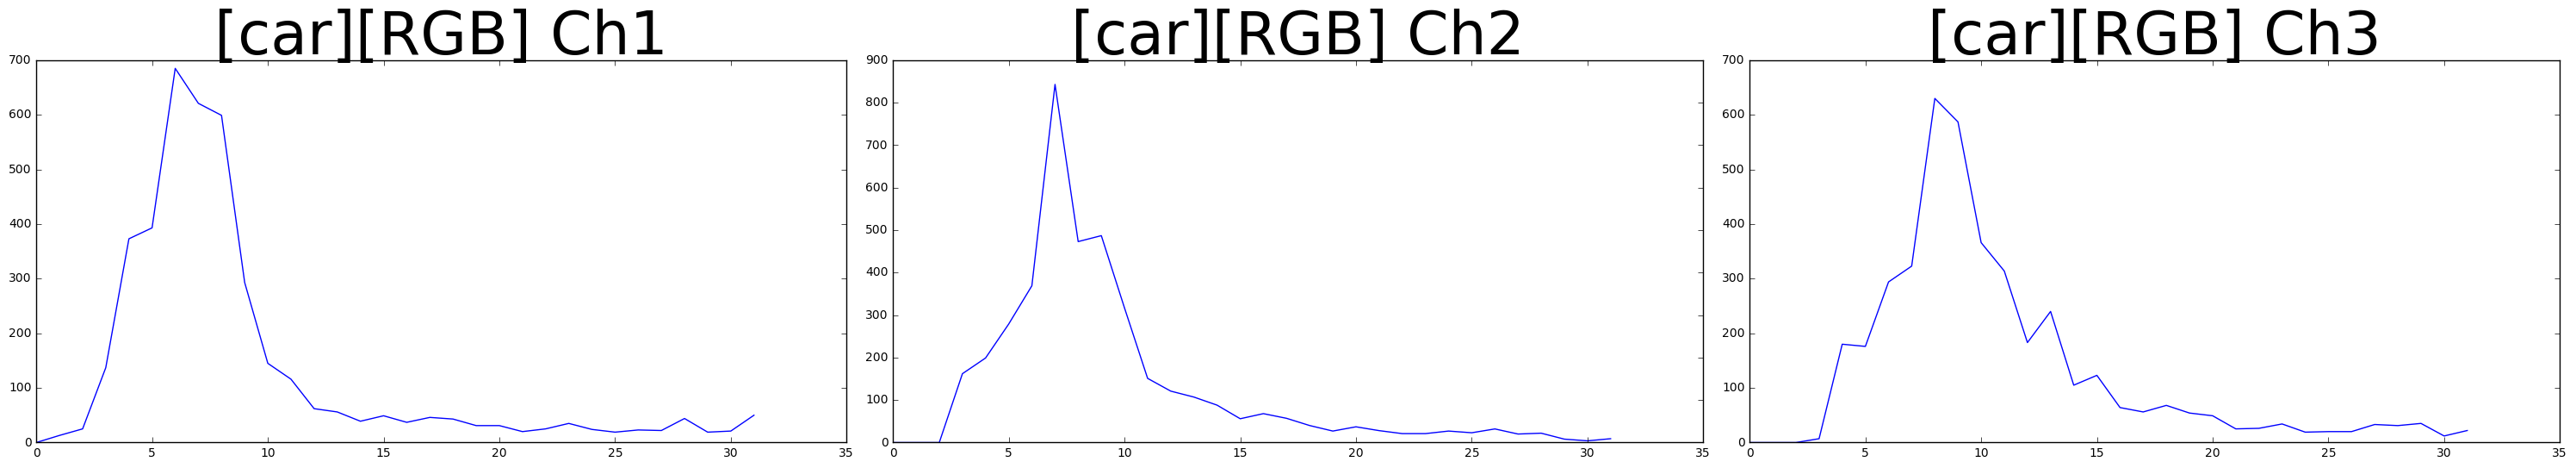

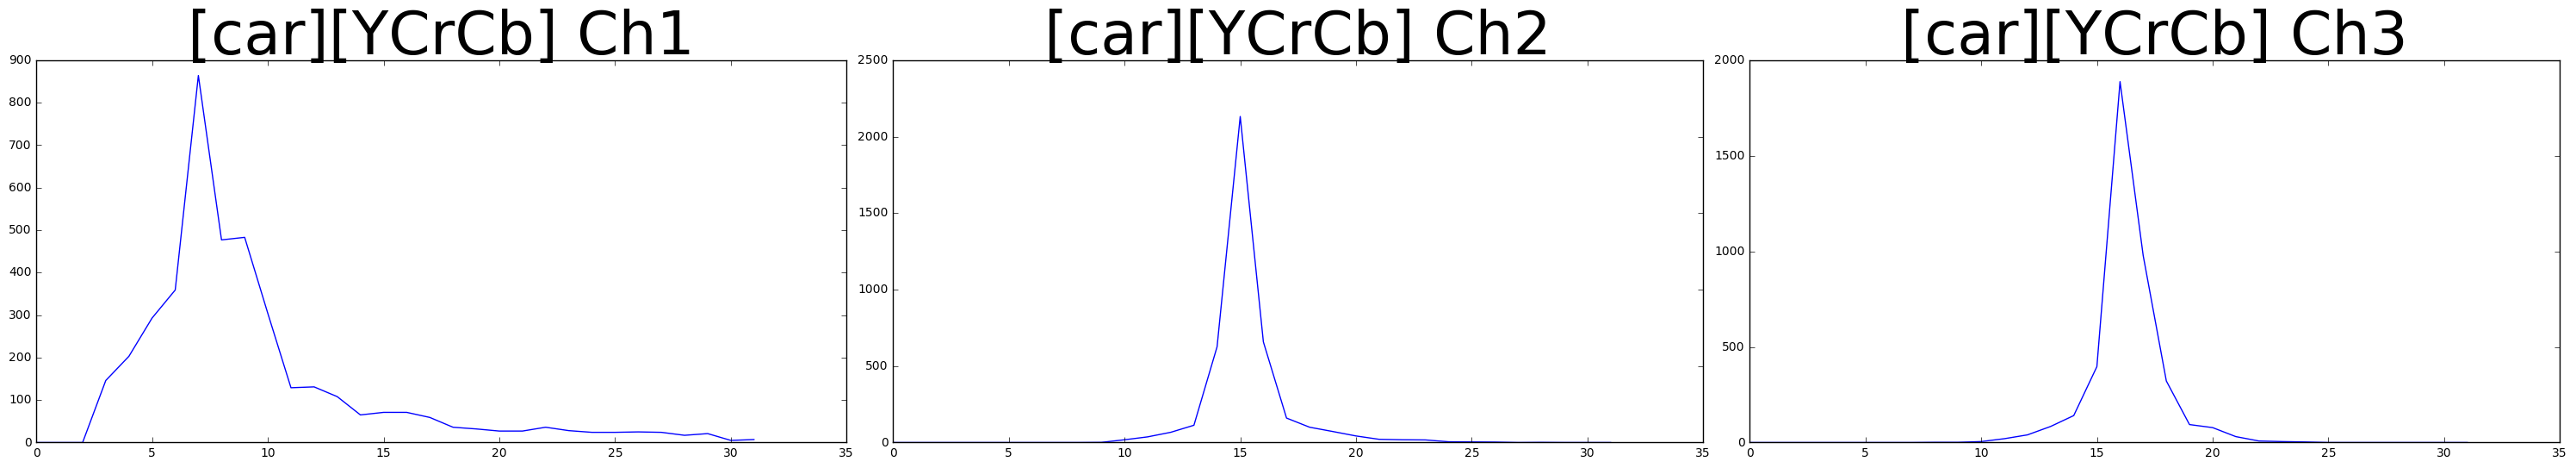

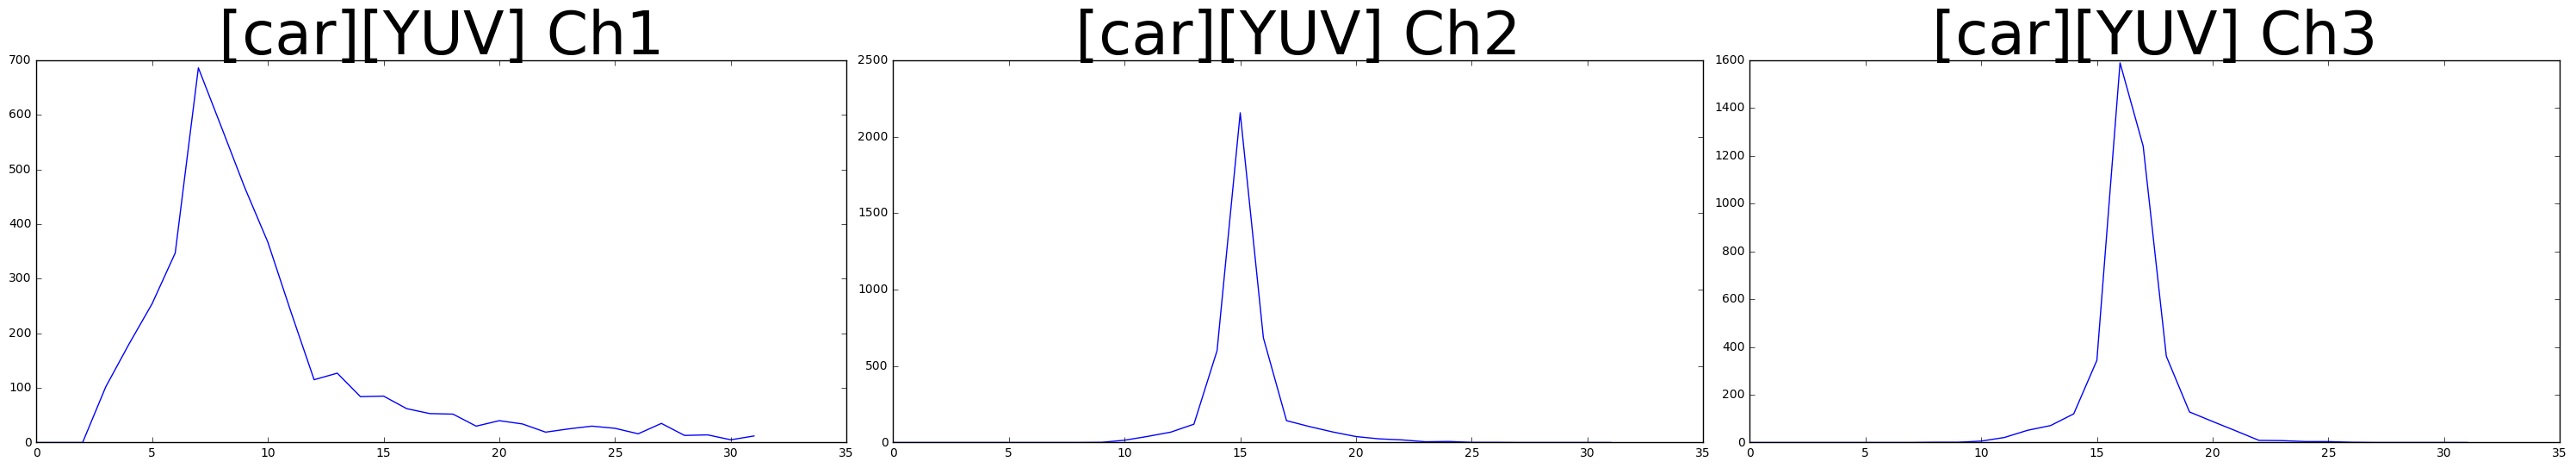

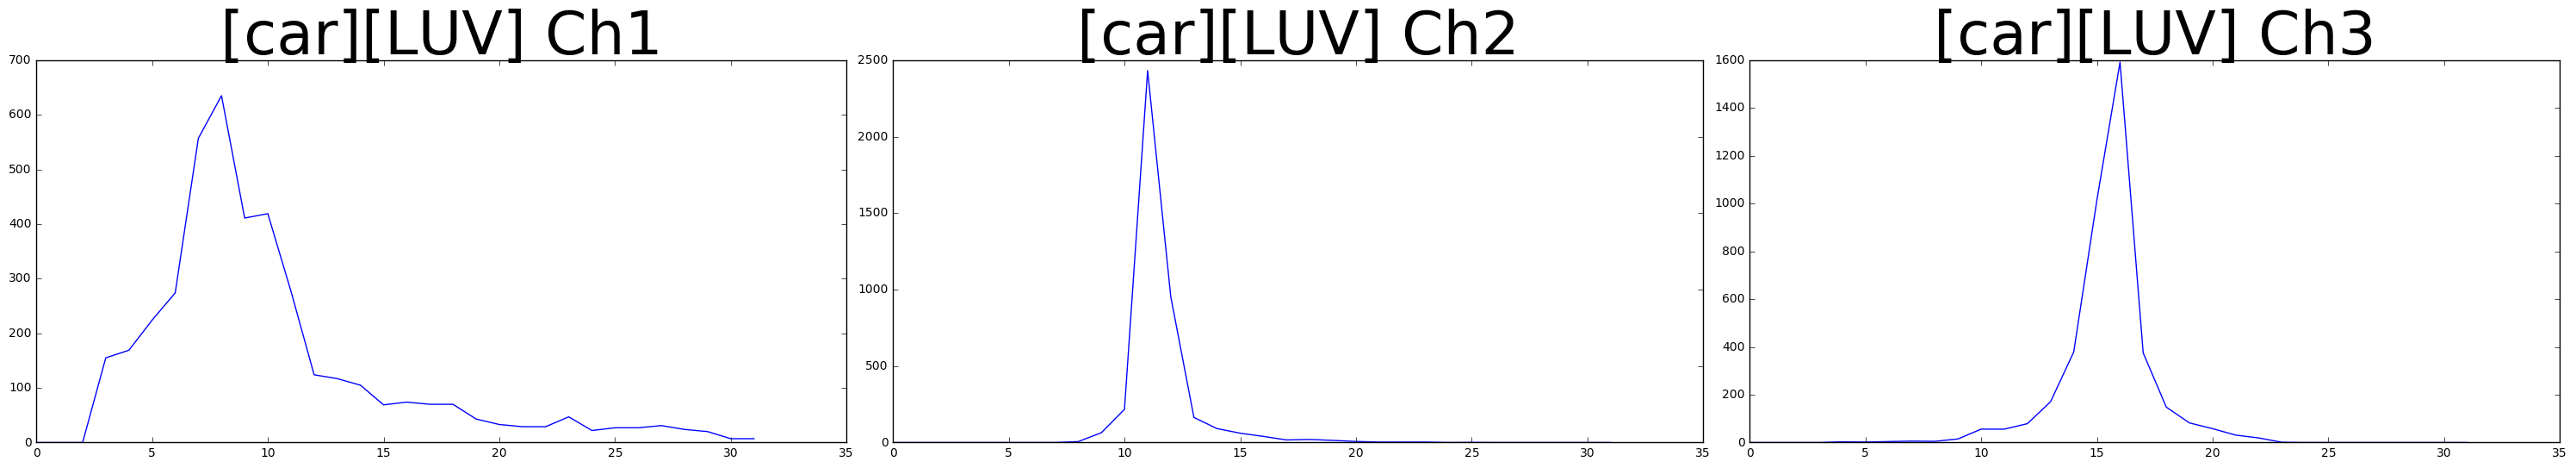

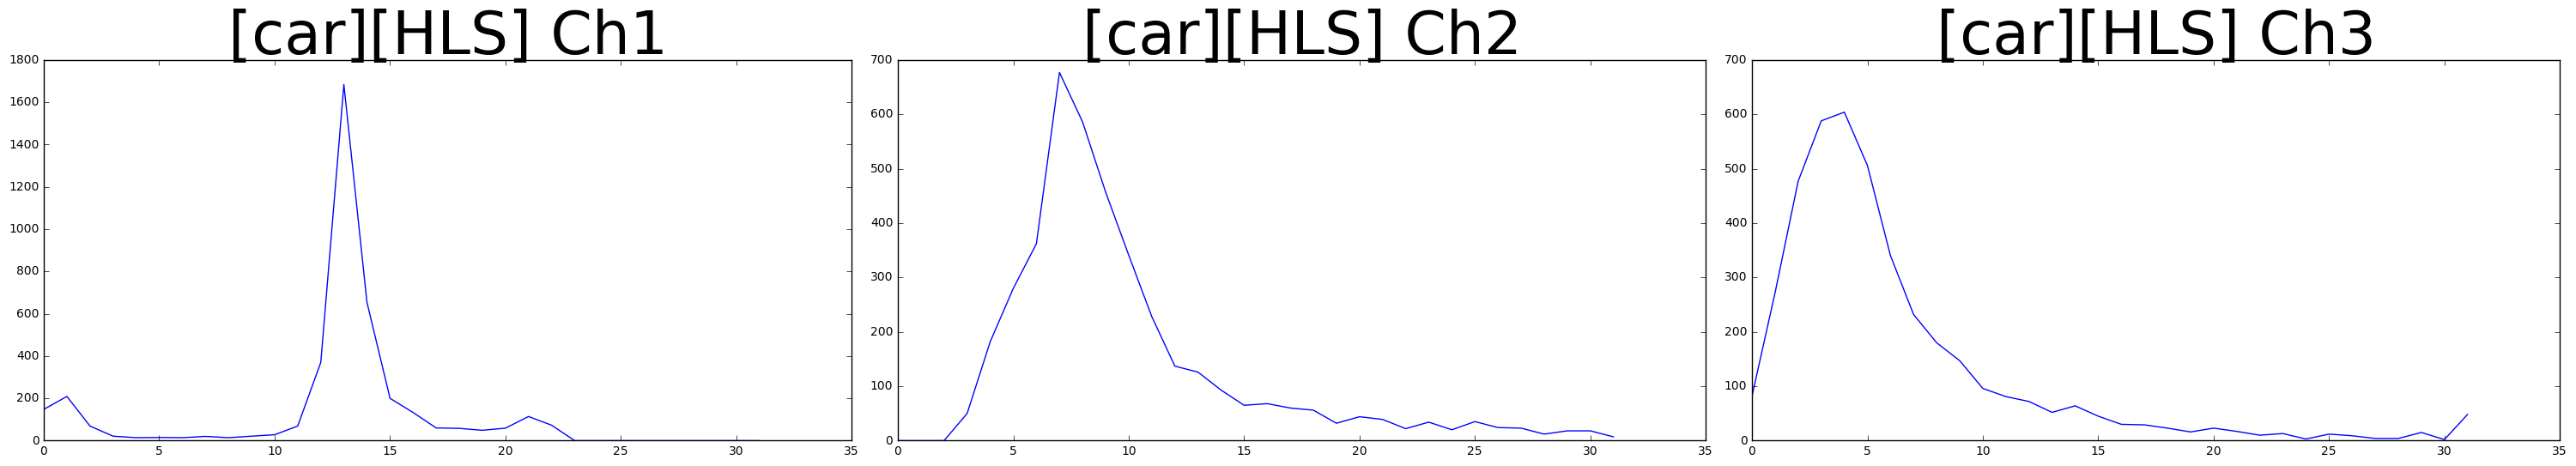

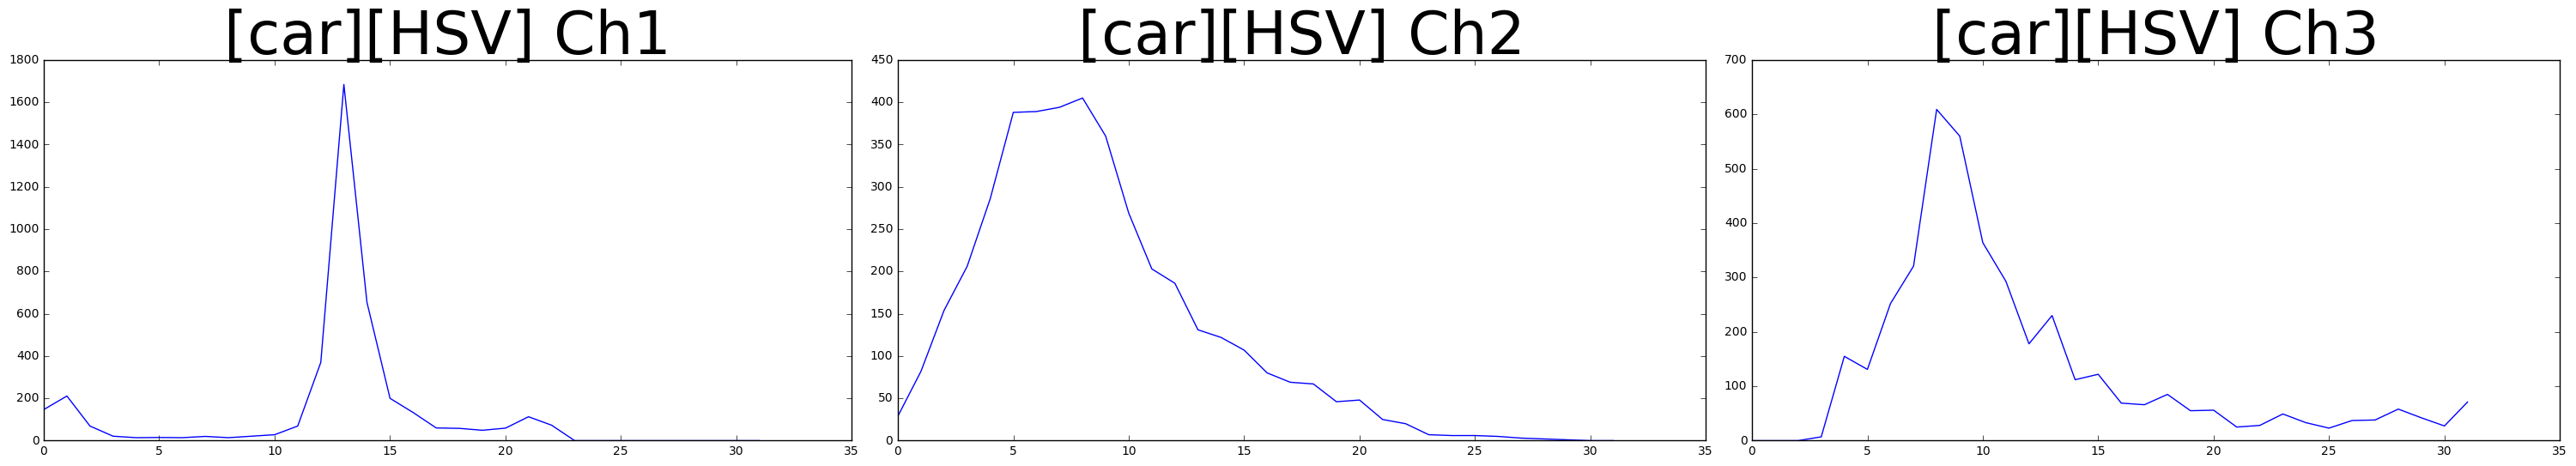

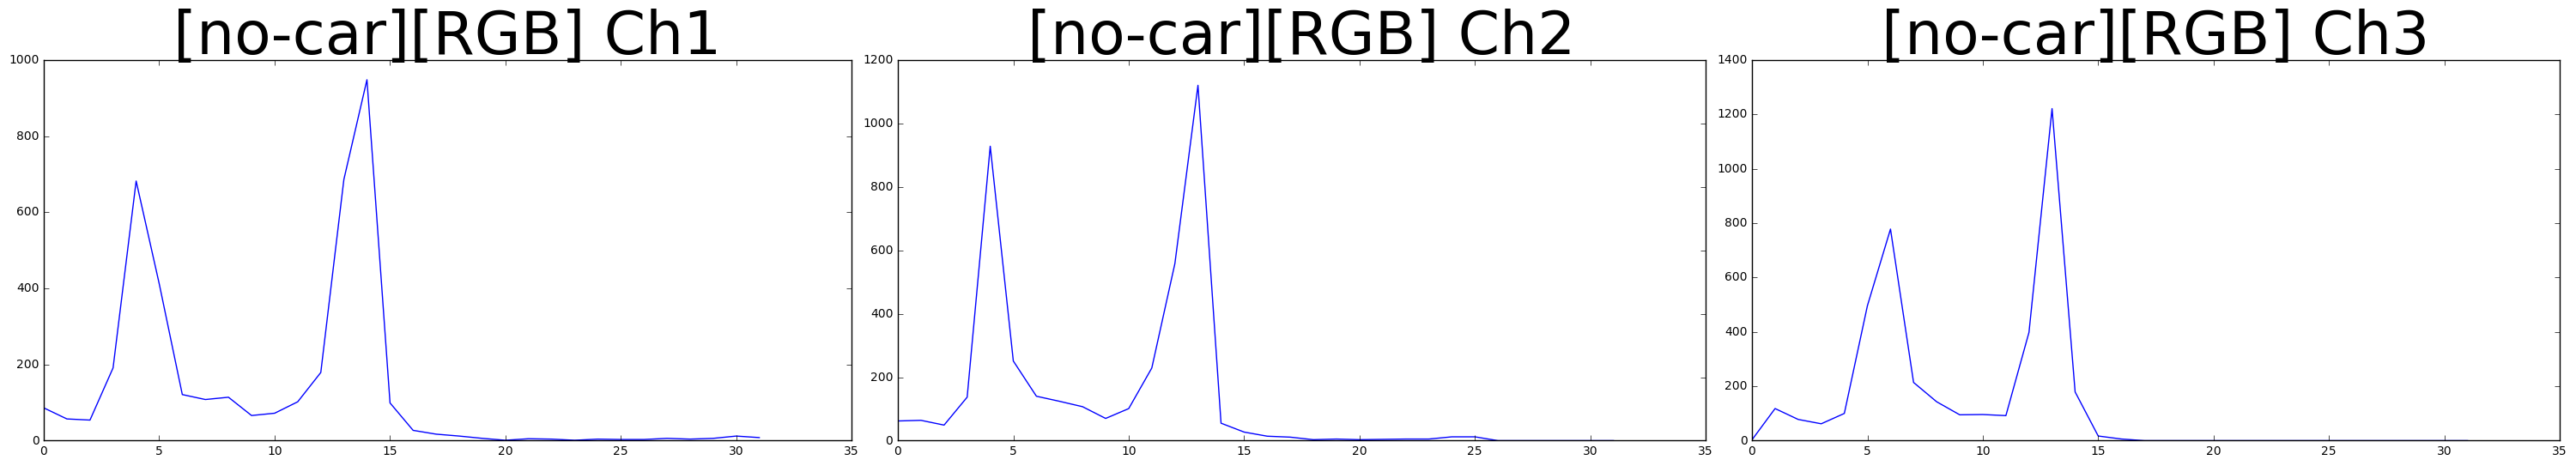

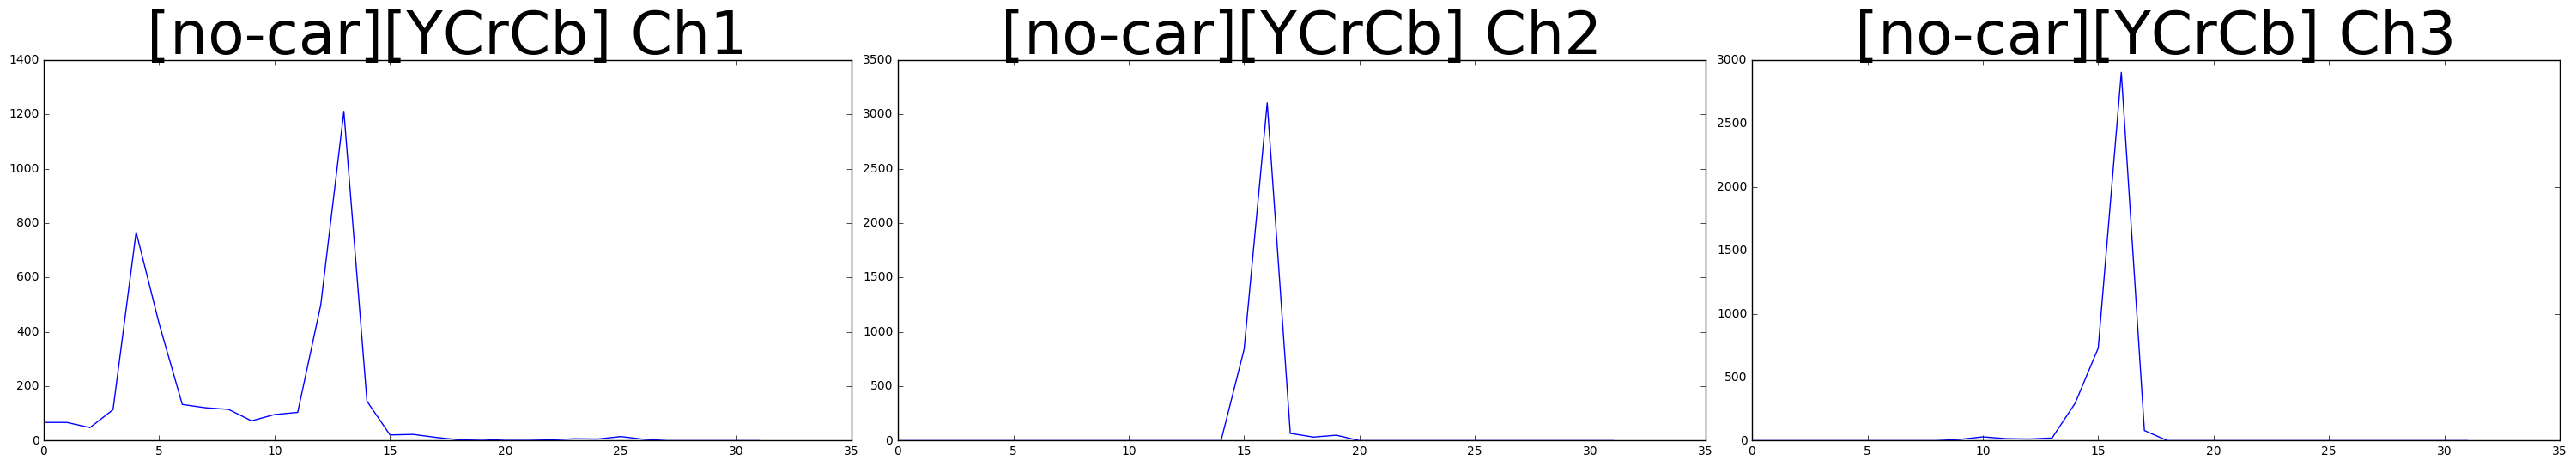

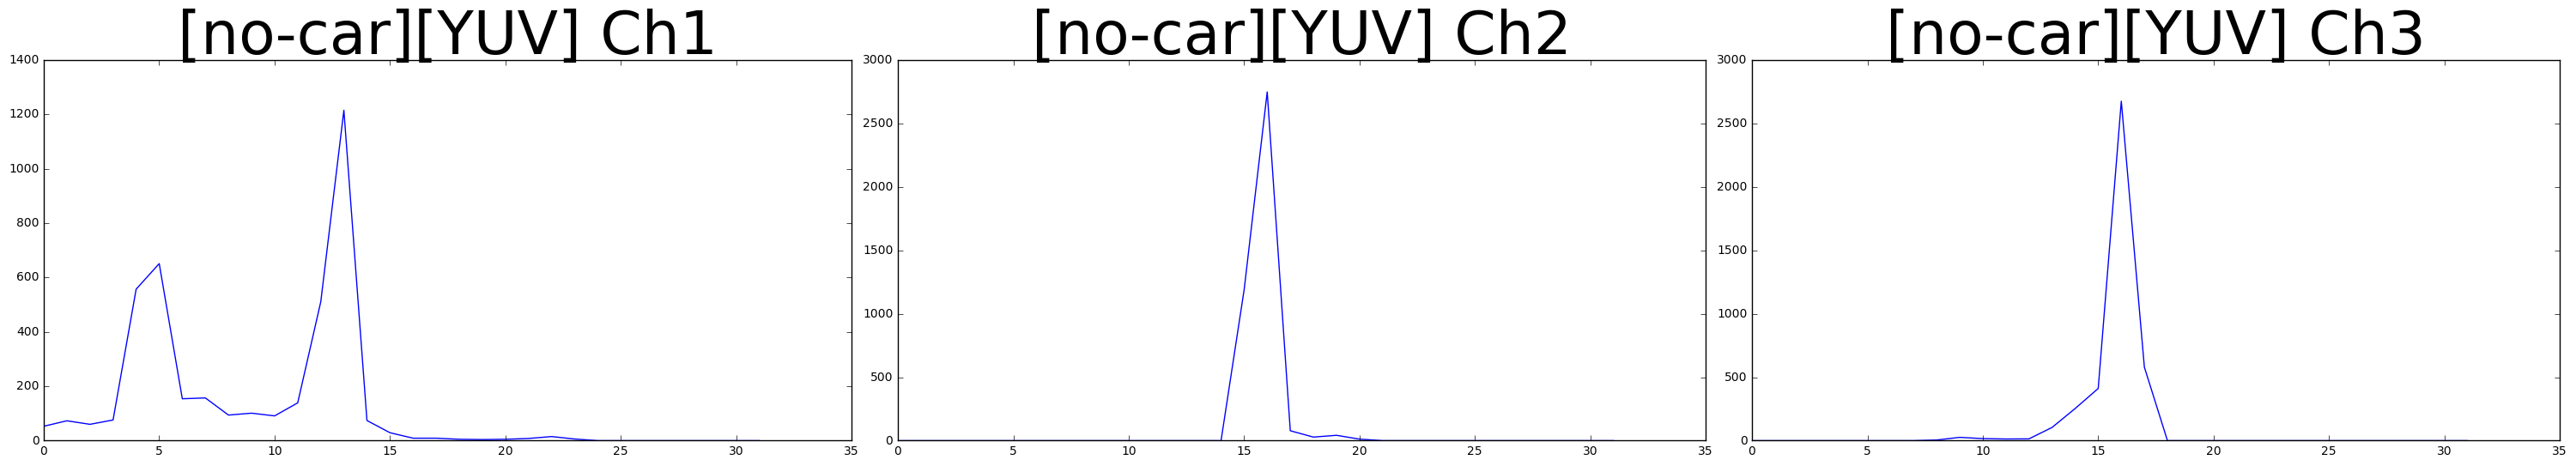

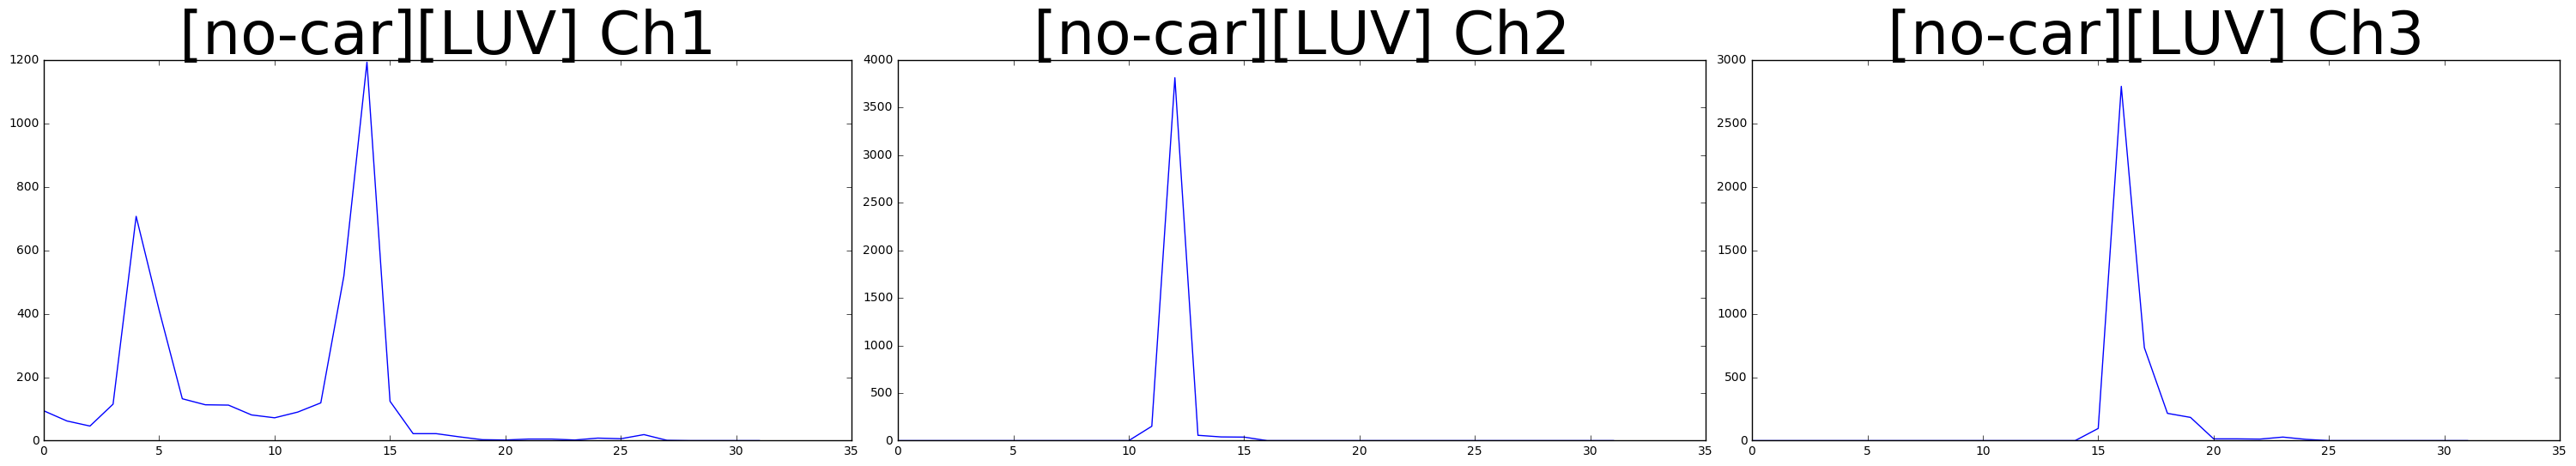

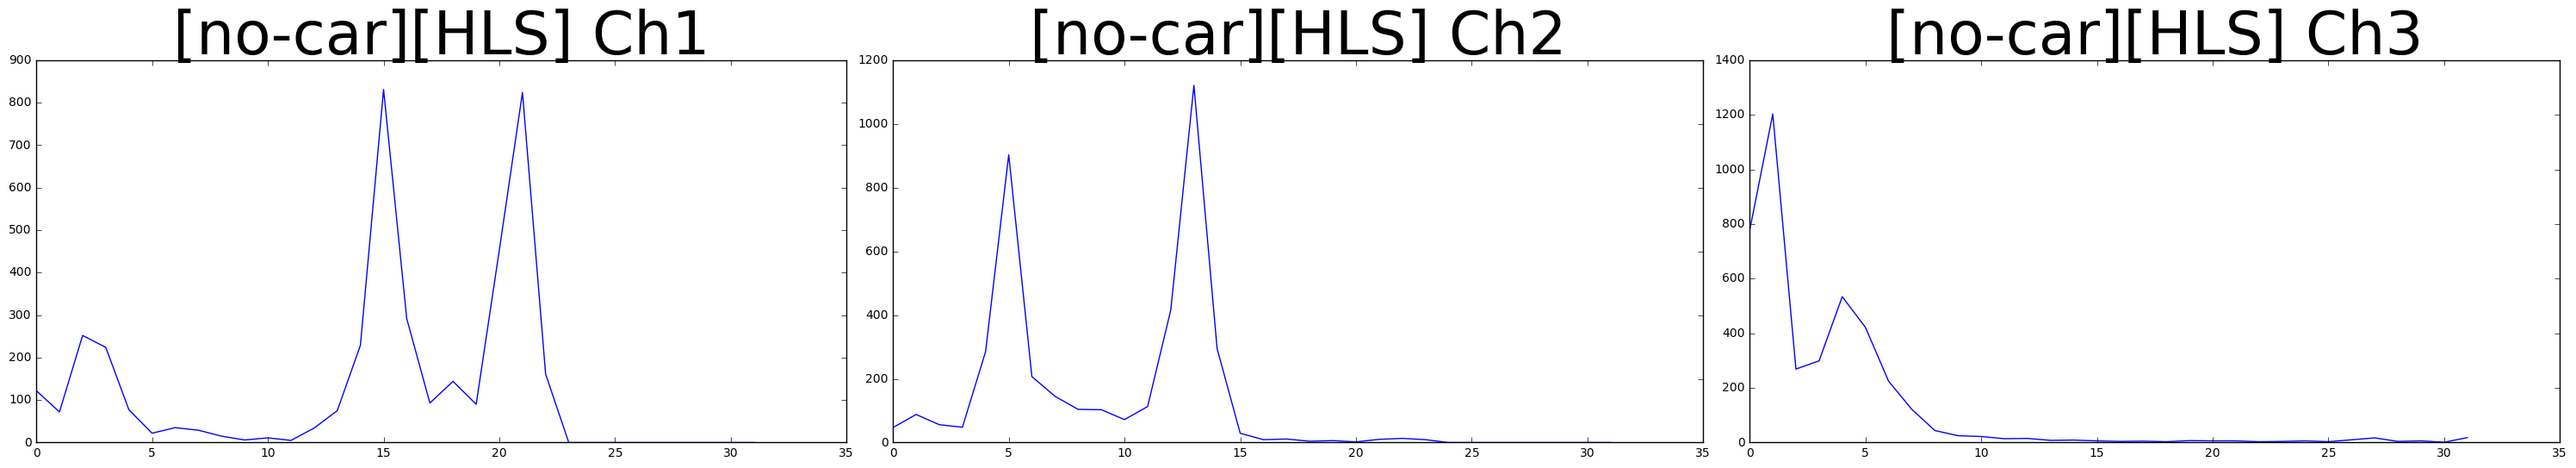

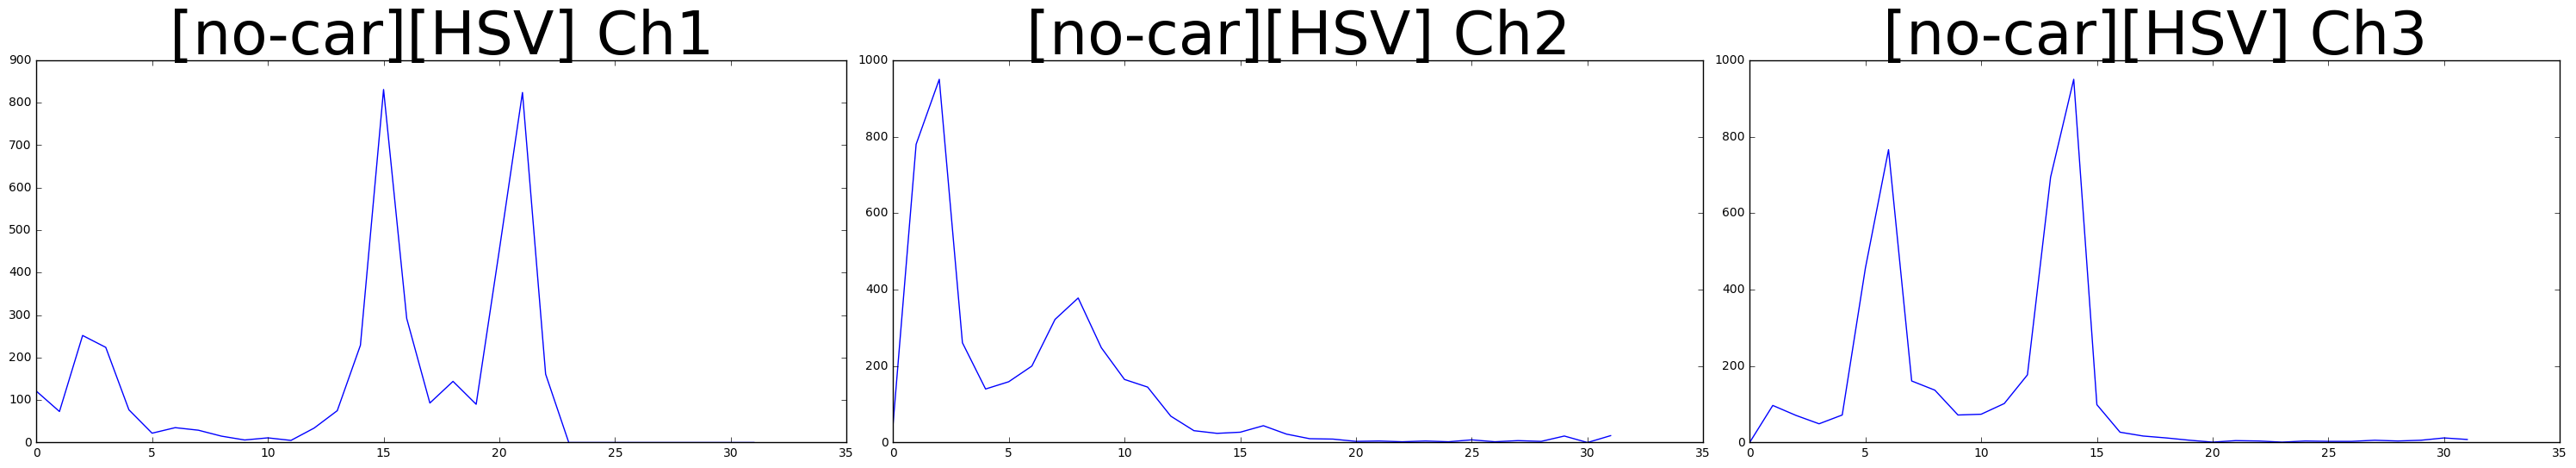

In [6]:
#Visualize the color histogram on the car image
color_hist(img_car, visualize=True, title='[car][RGB]')
color_hist(cv2.cvtColor(img_car, cv2.COLOR_RGB2YCrCb), visualize=True, title='[car][YCrCb]')
color_hist(cv2.cvtColor(img_car, cv2.COLOR_RGB2YUV), visualize=True, title='[car][YUV]')
color_hist(cv2.cvtColor(img_car, cv2.COLOR_RGB2LUV), visualize=True, title='[car][LUV]')
color_hist(cv2.cvtColor(img_car, cv2.COLOR_RGB2HLS), visualize=True, title='[car][HLS]')
color_hist(cv2.cvtColor(img_car, cv2.COLOR_RGB2HSV), visualize=True, title='[car][HSV]')

#Test the color histogram on the notcar image
color_hist(img_notcar, visualize=True, title='[no-car][RGB]')
color_hist(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2YCrCb), visualize=True, title='[no-car][YCrCb]')
color_hist(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2YUV), visualize=True, title='[no-car][YUV]')
color_hist(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2LUV), visualize=True, title='[no-car][LUV]')
color_hist(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2HLS), visualize=True, title='[no-car][HLS]')
color_hist(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2HSV), visualize=True, title='[no-car][HSV]')

In [35]:
def bin_spatial(img, size=(32, 32)):
    '''
    Function to compute binned color features  
    '''
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

## 3. Mess around with histogram of gradients (HOG) using different colorspaces and other parameters

In [36]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''
    Function to return HOG features and visualization
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

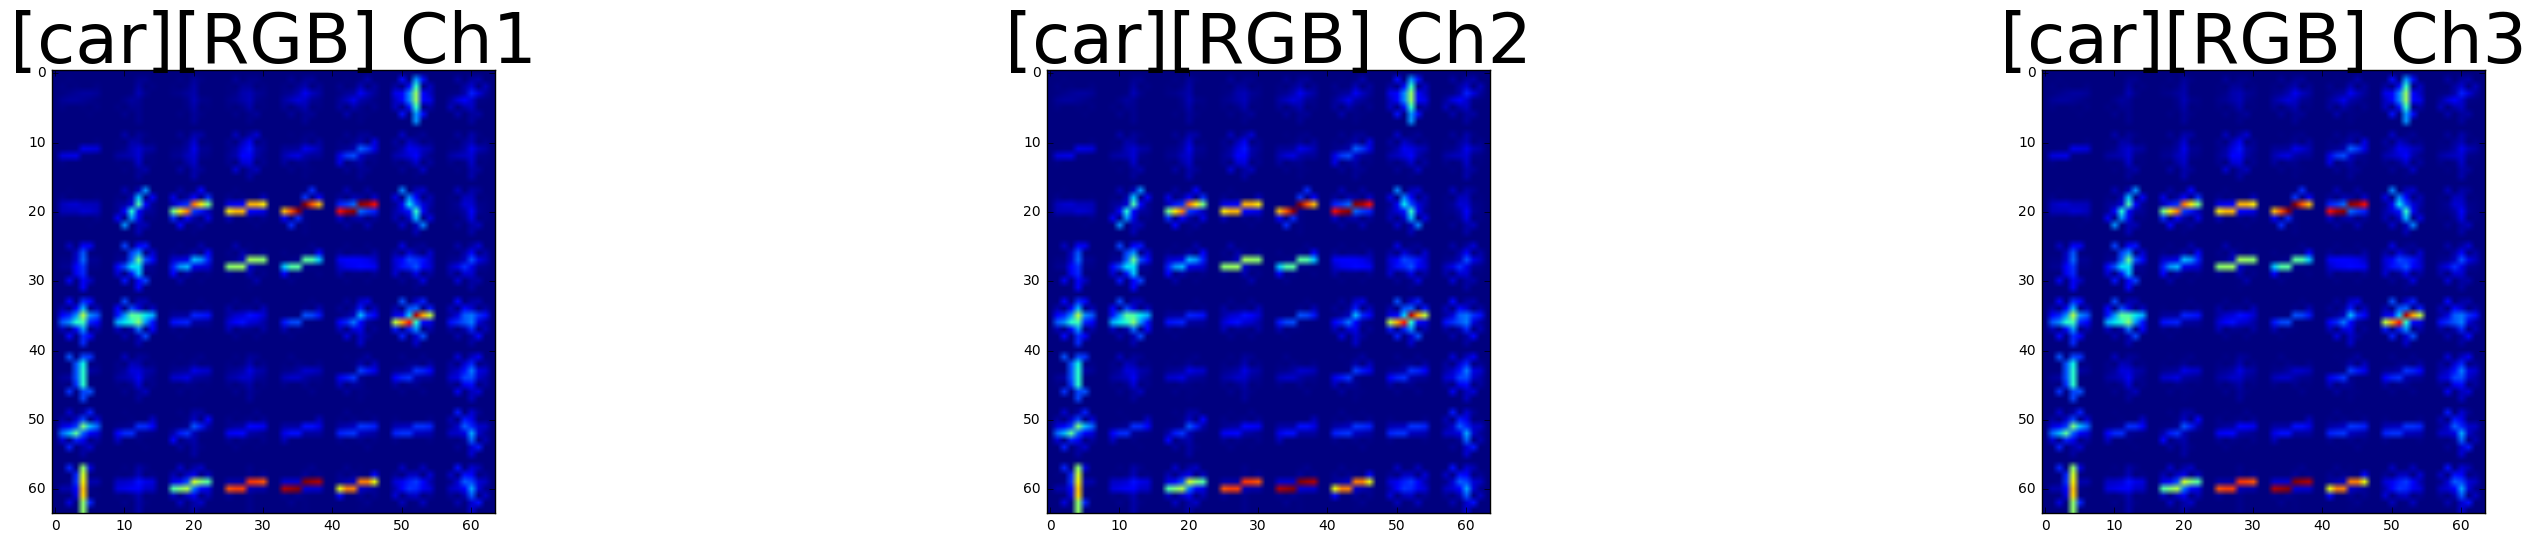

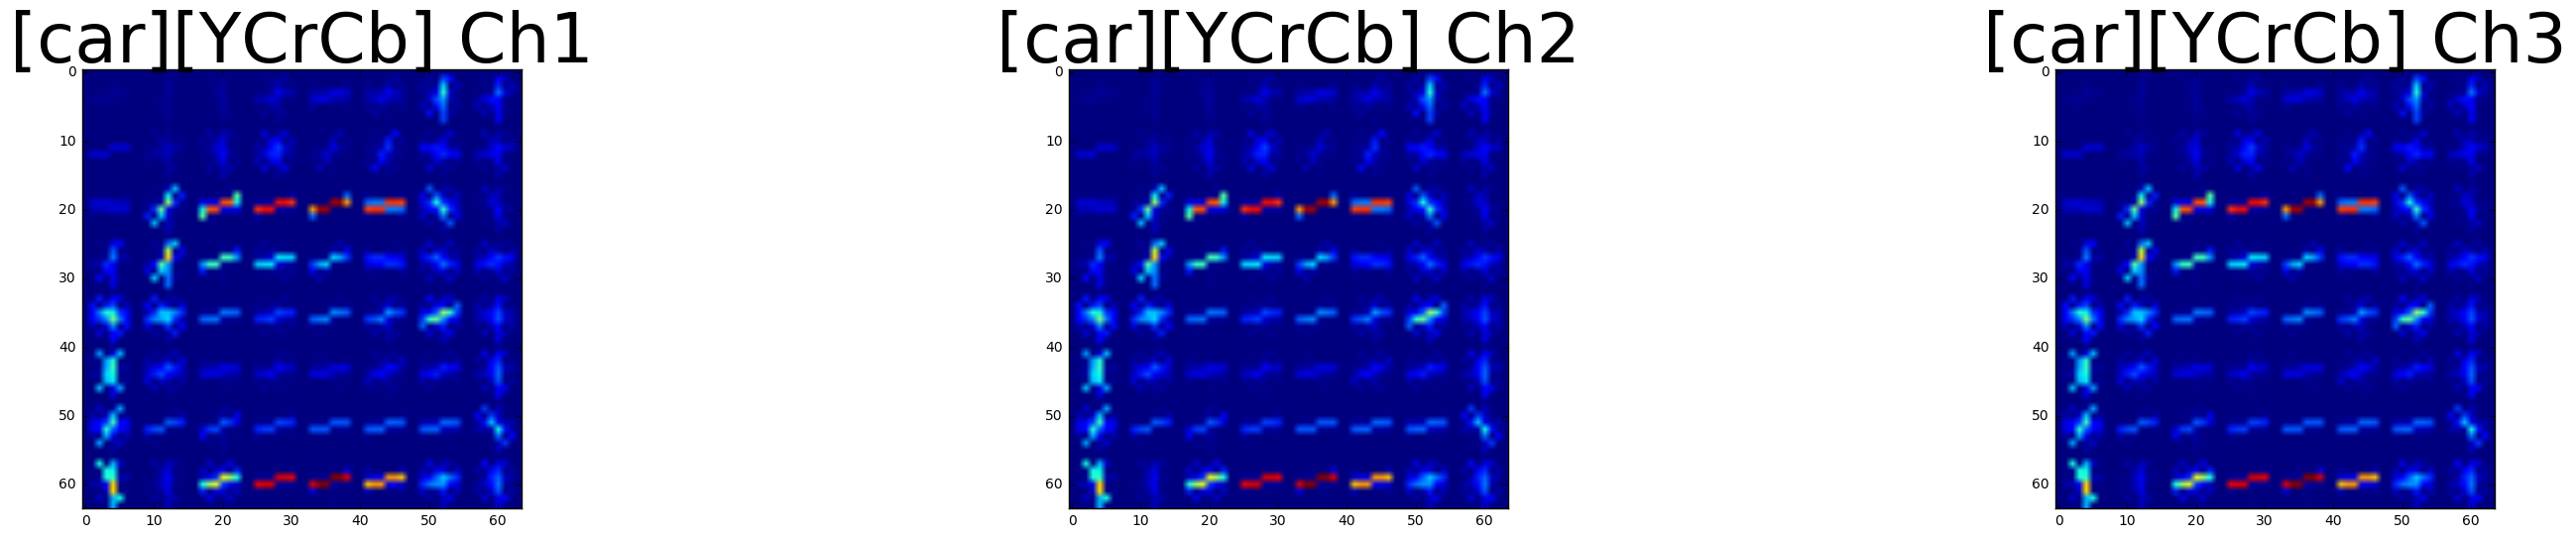

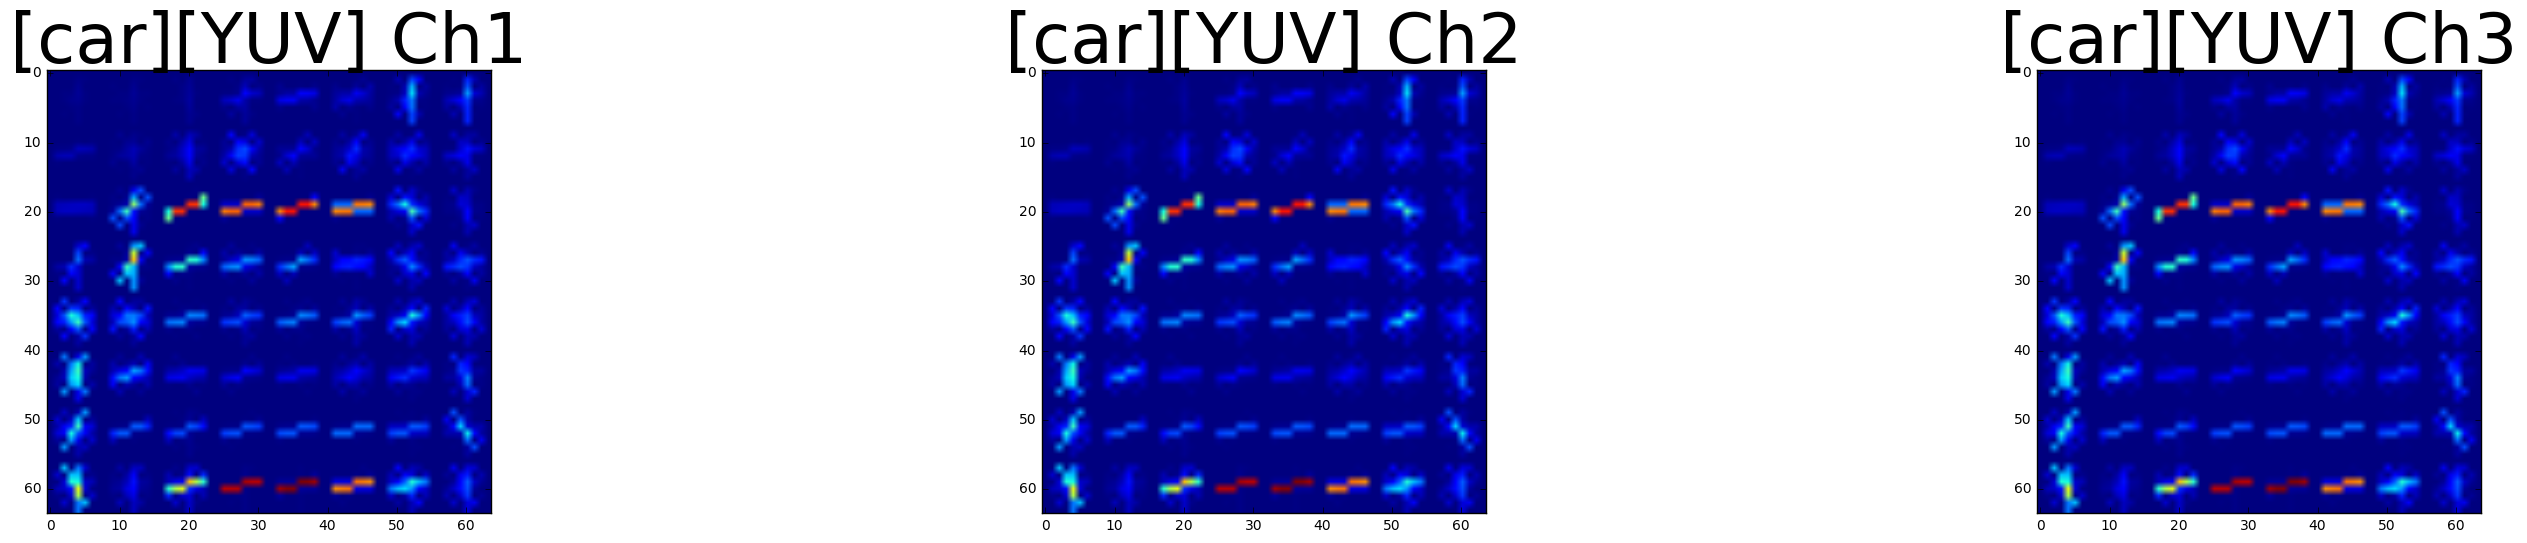

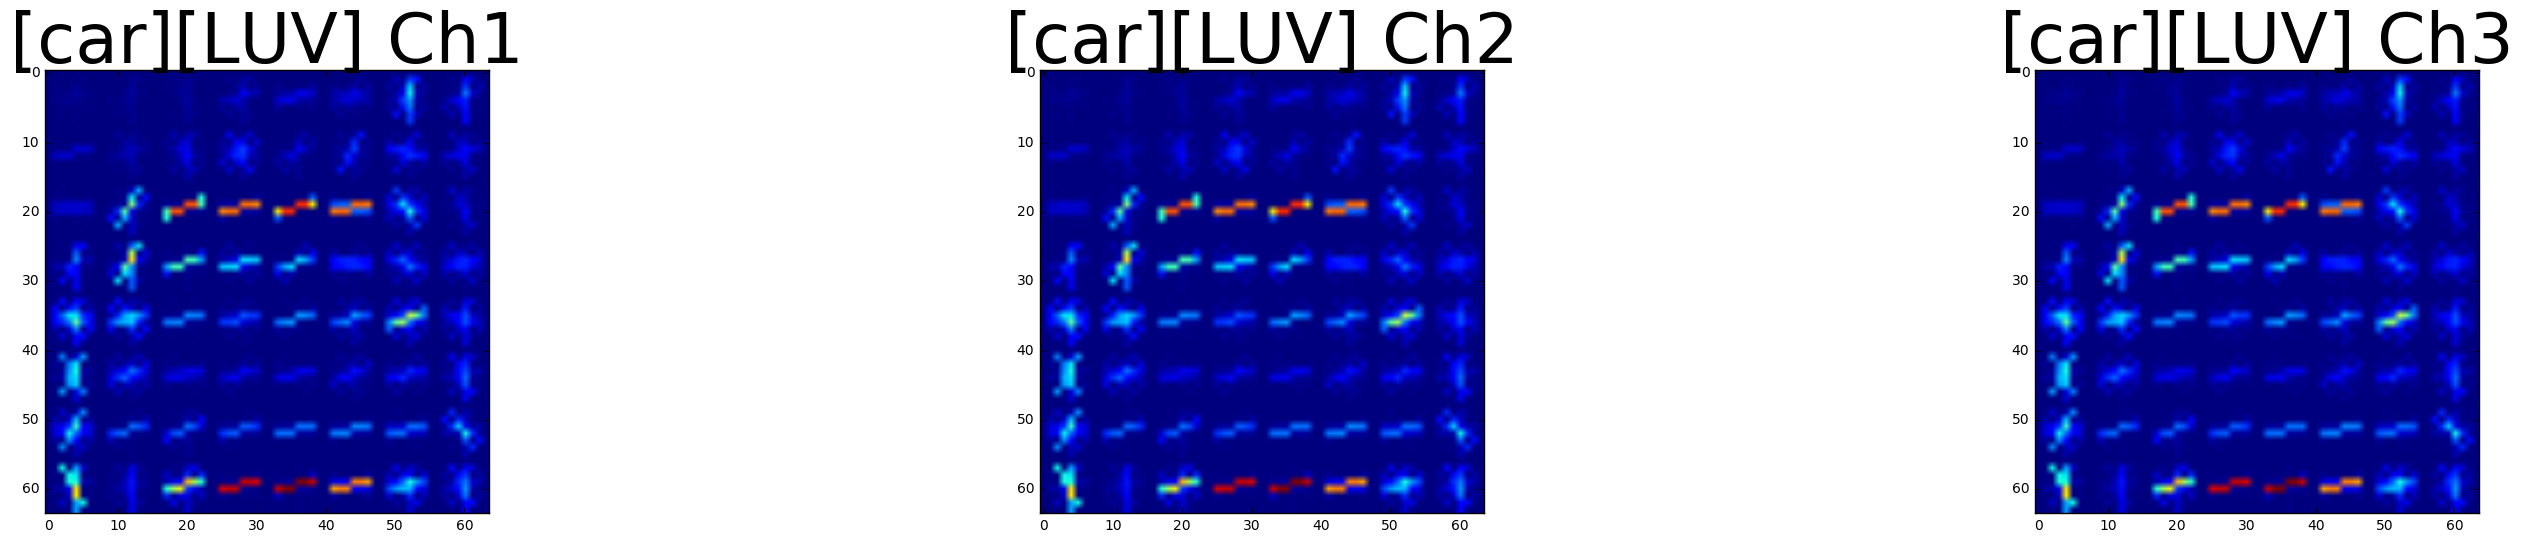

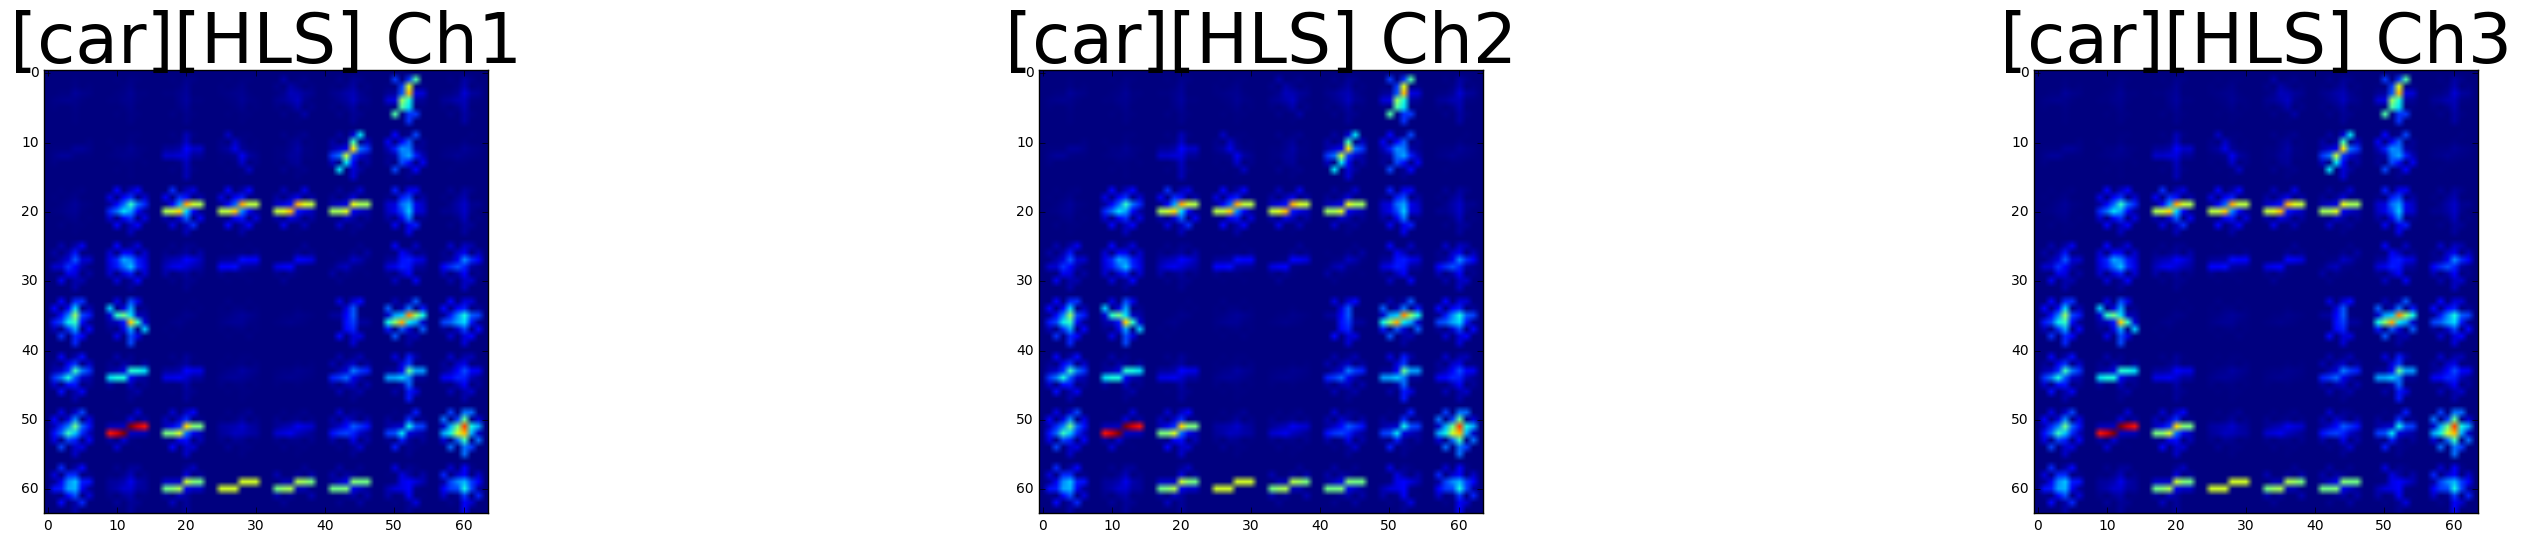

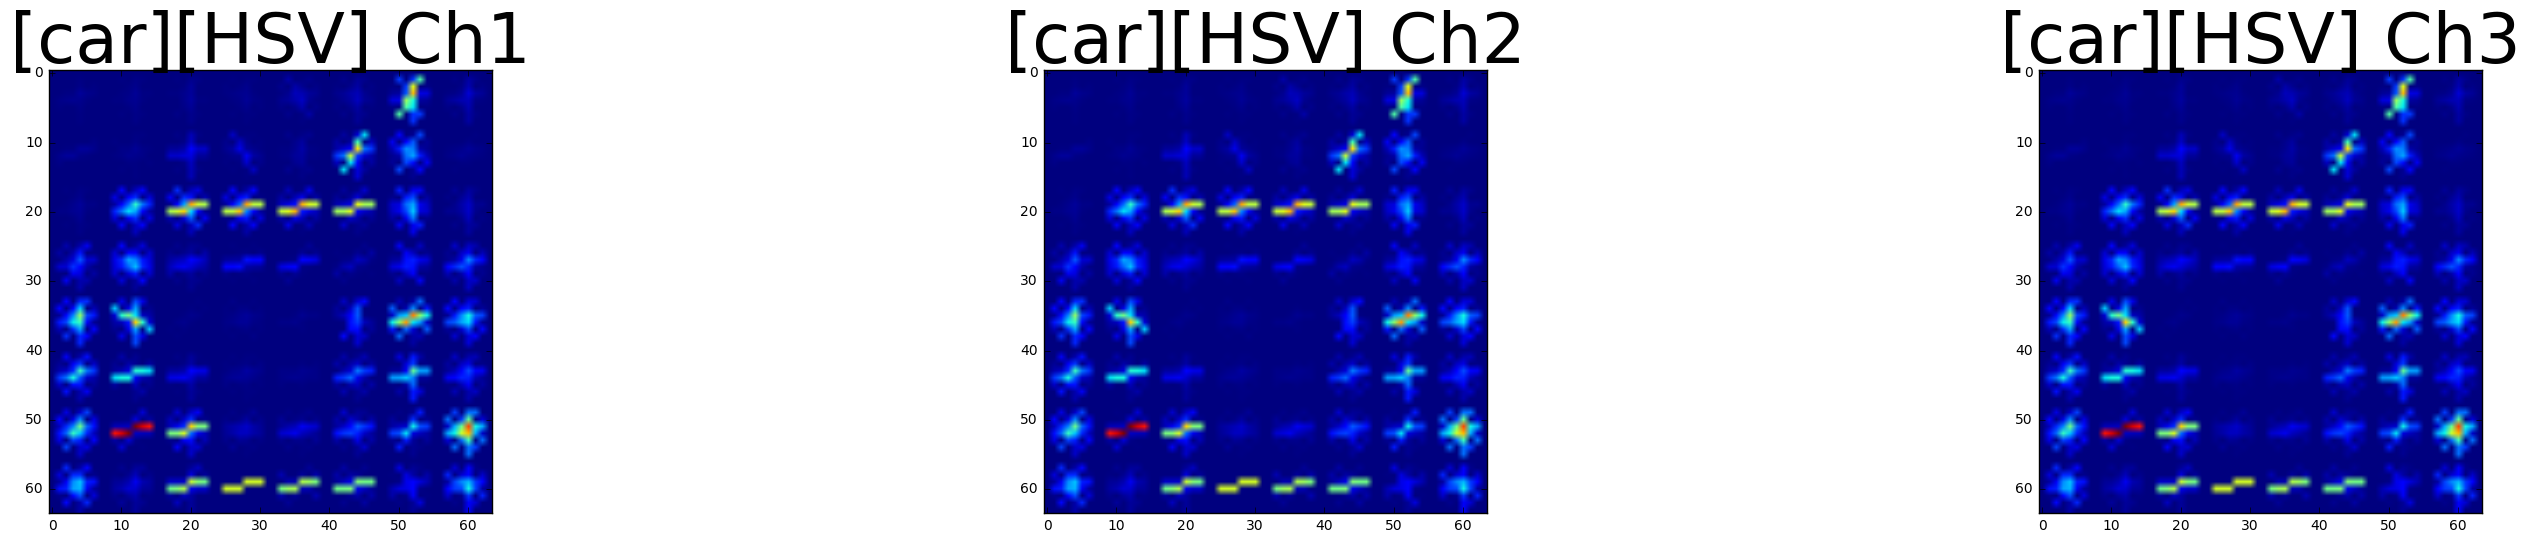

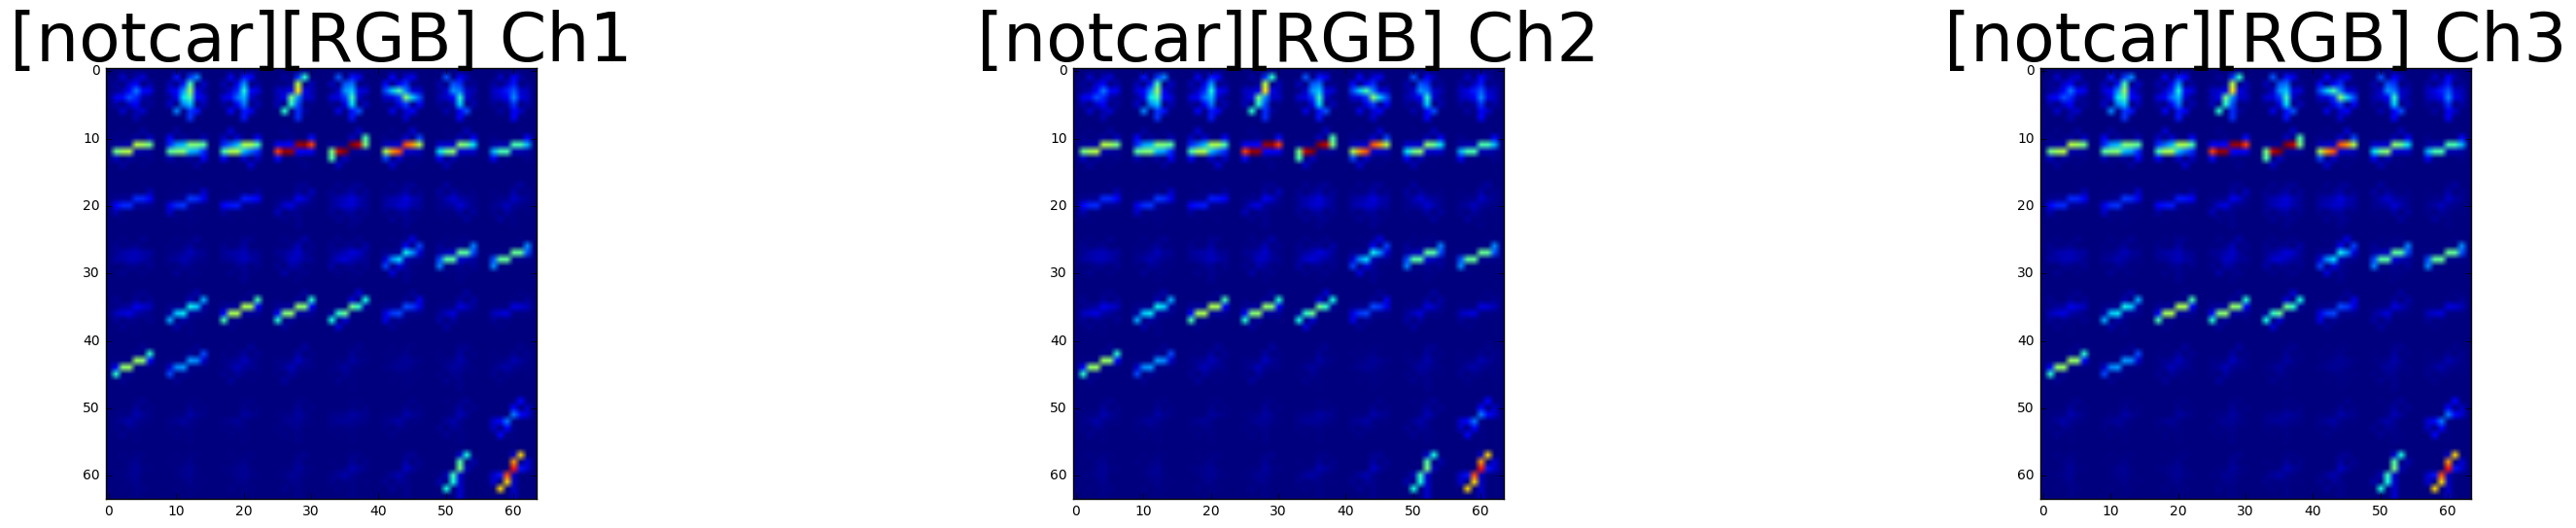

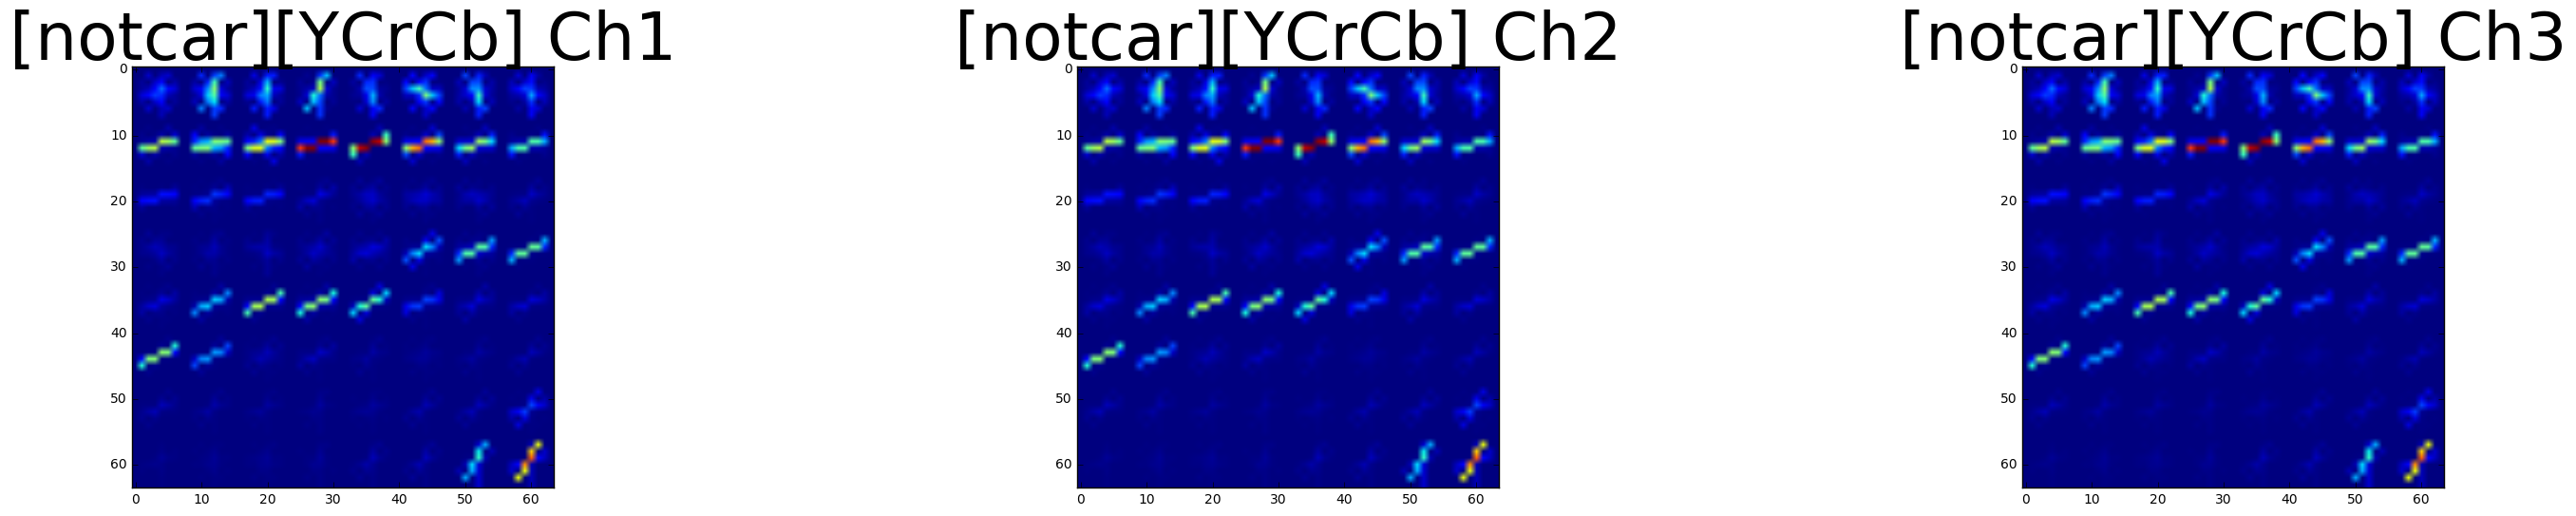

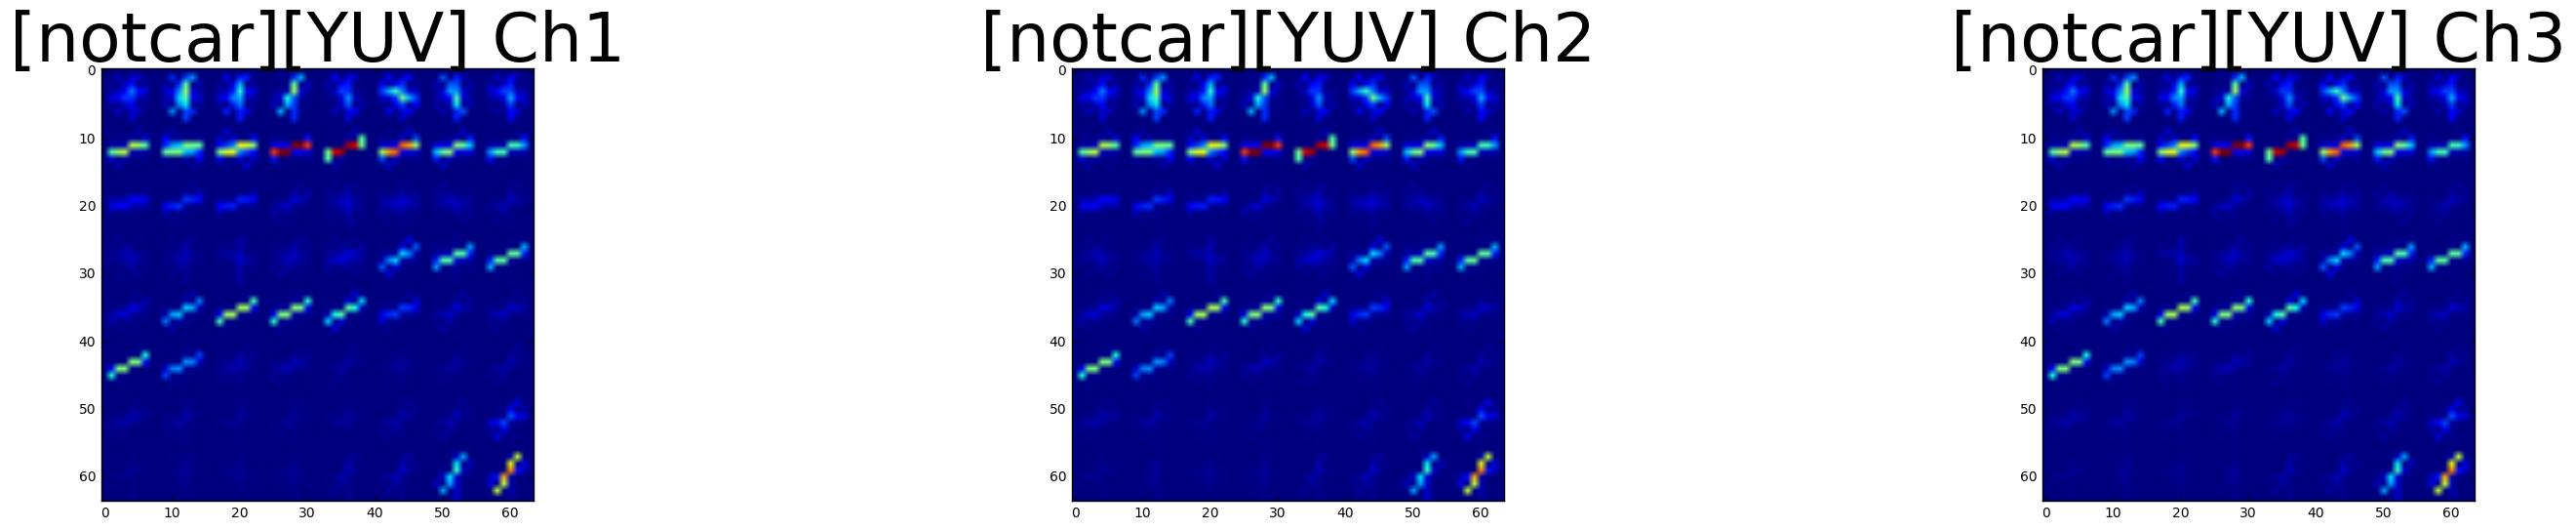

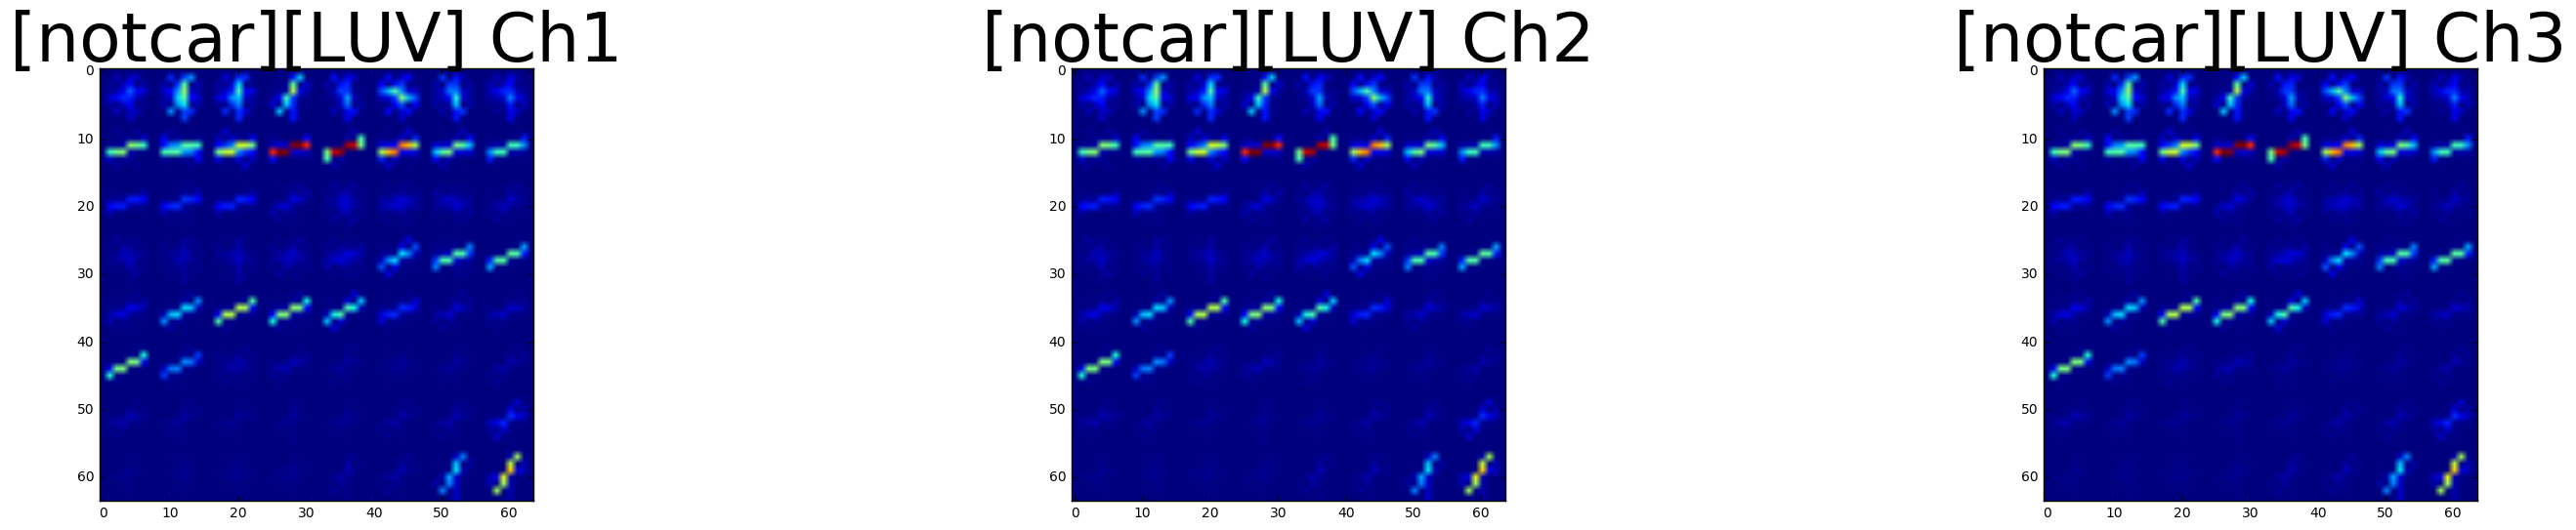

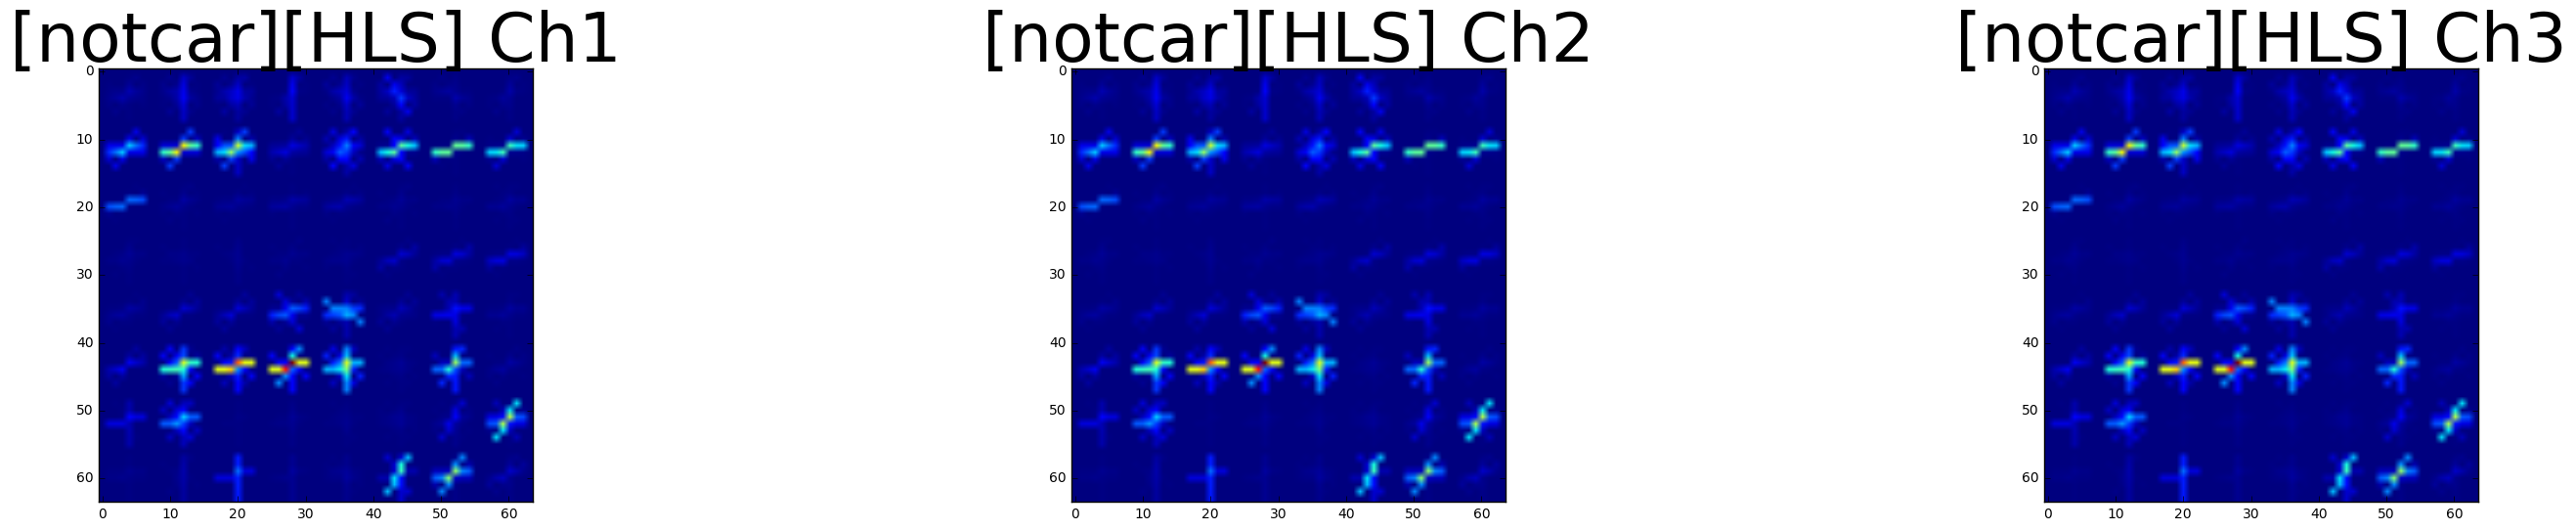

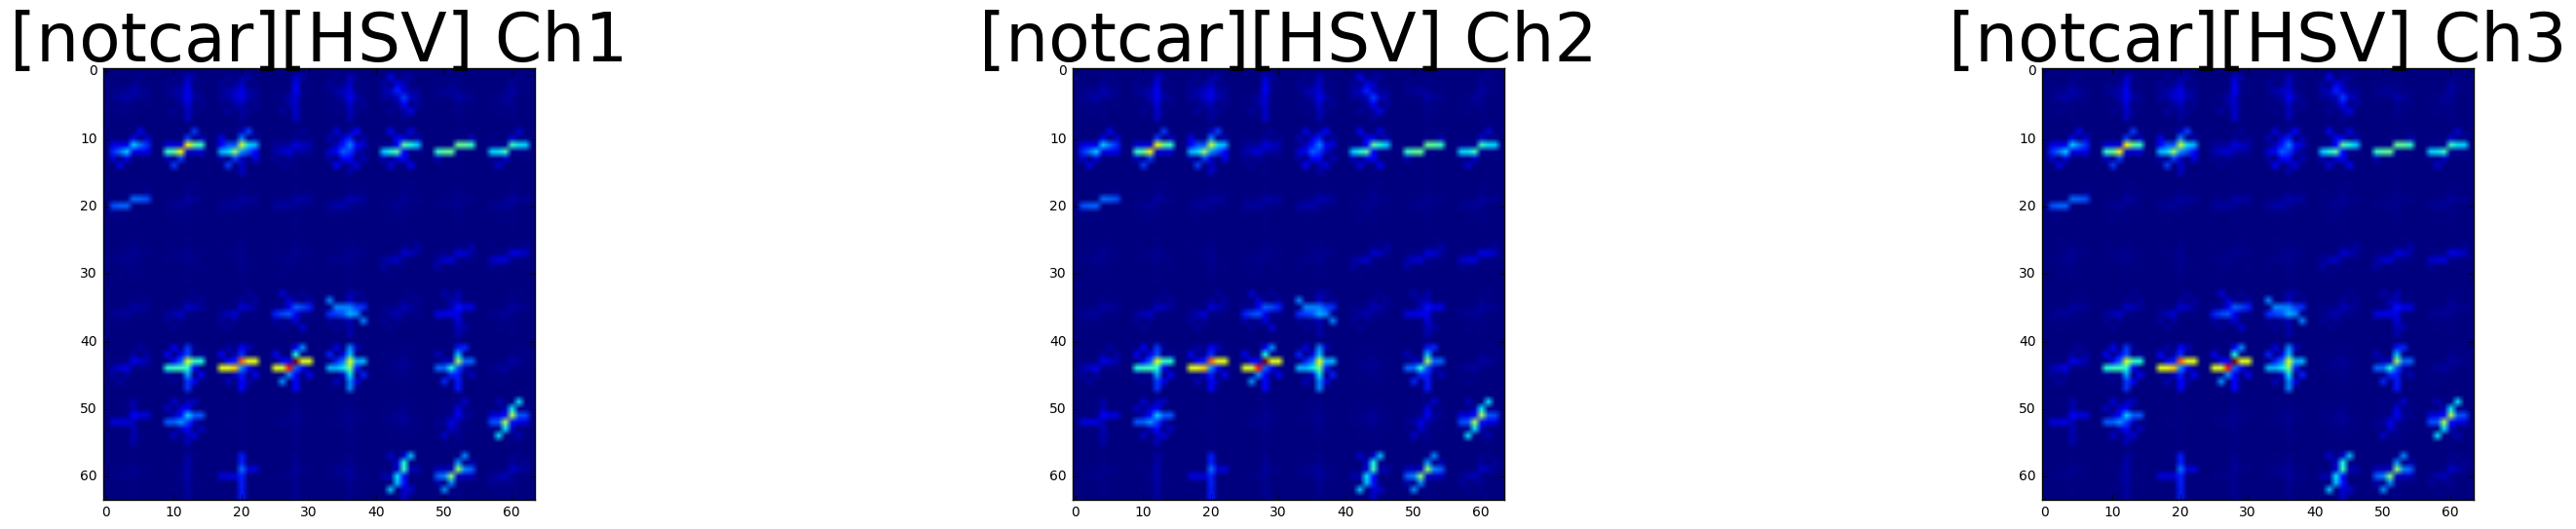

In [8]:
def check_hog(img, title=None):
    hog_features=[]
    orient=9
    pix_per_cell=8
    cell_per_block=2

    # Plot the result
    f, ax = plt.subplots(1, 3, figsize=(30, 5))
    f.tight_layout()

    for channel in range(img.shape[2]):
        hog_features.append(get_hog_features(img[:,:,channel], 
                orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True))

        ax[channel].imshow(hog_features[0][1])
        ax[channel].set_title(title+' Ch'+str(channel+1), fontsize=50)

#short test of the HOG on car image
check_hog(img_car, title='[car][RGB]')
check_hog(cv2.cvtColor(img_car, cv2.COLOR_RGB2YCrCb), title='[car][YCrCb]')
check_hog(cv2.cvtColor(img_car, cv2.COLOR_RGB2YUV), title='[car][YUV]')
check_hog(cv2.cvtColor(img_car, cv2.COLOR_RGB2LUV), title='[car][LUV]')
check_hog(cv2.cvtColor(img_car, cv2.COLOR_RGB2HLS), title='[car][HLS]')
check_hog(cv2.cvtColor(img_car, cv2.COLOR_RGB2HSV), title='[car][HSV]')

#and why not test the not-car image too?
#short test of the HOG on car image
check_hog(img_notcar, title='[notcar][RGB]')
check_hog(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2YCrCb), title='[notcar][YCrCb]')
check_hog(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2YUV), title='[notcar][YUV]')
check_hog(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2LUV), title='[notcar][LUV]')
check_hog(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2HLS), title='[notcar][HLS]')
check_hog(cv2.cvtColor(img_notcar, cv2.COLOR_RGB2HSV), title='[notcar][HSV]')

## 4. Combine the features

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    '''
    Function to extract features from a list of images
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 5. Set parameters for feature extraction

In [20]:
cspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 650] # Min and max in y to search in slide_window()

## 6. Do the feature extraction for datasets

In [11]:
import time
### Extract the features
t=time.time()
car_features = extract_features(cars, color_space=cspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=cspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features')

94.39 Seconds to extract features


## 7. Normalize the features and check the result

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

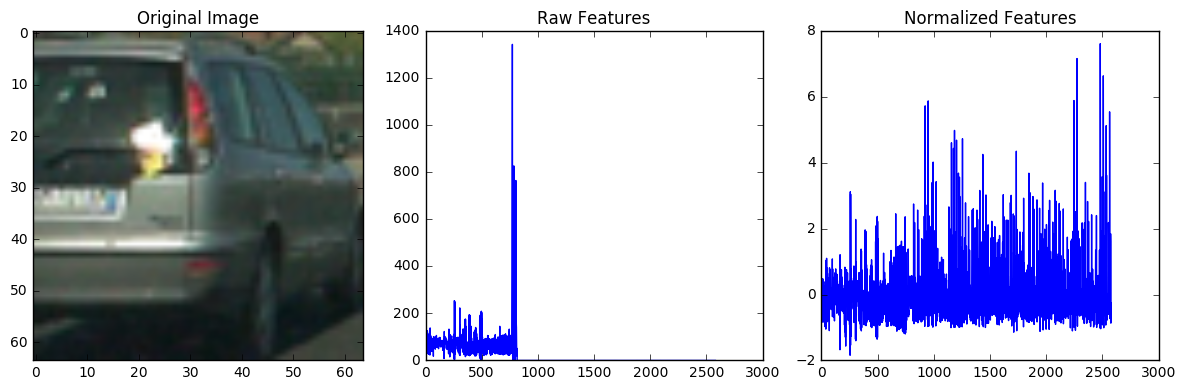

In [21]:
# Check the result
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(cv2.imread(cars[car_ind]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [22]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## 8. Train the classifier

In [23]:
print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (16, 16) and 16 histogram bins 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
15.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
0.0 Seconds to predict 10 labels with SVC


In [34]:
# save the classifier and scaler
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["X_scaler"] = X_scaler
pickle.dump( svc_pickle, open( "svc_pickle.p", "wb" ) )

## 9. Search and Classify windows

In [25]:
# From Lesson 34 Search and Classify

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    '''
    Function that takes an image, start and stop positions in both x and y, 
    window size (x and y dimensions), and overlap fraction (for both x and y)
    '''
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Visualize the search windows

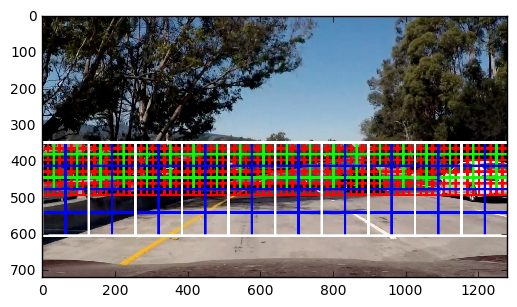

In [39]:
img = cv2.cvtColor(cv2.imread('./test_images/test5.jpg'), cv2.COLOR_BGR2RGB)
#bboxes=slide_window(img, x_start_stop=[None, None], y_start_stop=(400, 500), 
#                    xy_window=(32,32), xy_overlap=(0.5, 0.5))

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=(350, 500), 
                    xy_window=(32,32), xy_overlap=(0.5, 0.5))
img = draw_boxes(img, windows, color=(255, 0, 0))

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=(350, 500), 
                    xy_window=(64,64), xy_overlap=(0.5, 0.5))
img = draw_boxes(img, windows, color=(0, 255, 0))

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))
img = draw_boxes(img, windows, color=(0, 0, 255))

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(256,256), xy_overlap=(0.5, 0.5))
img = draw_boxes(img, windows, color=(255, 255, 255))

plt.imshow(img)


In [27]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Lesson 37 Multiple Detections & False Positives
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [28]:
def process_image(image):    
    
    global heat
    
    heat=0.85*heat # changed from 0.9 to 0.85
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=(400, 500), 
                    xy_window=(32,32), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=(400, 500), 
                    xy_window=(64,64), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(256,256), xy_overlap=(0.5, 0.5))    
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
    #########
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3) #increased from 2 to 3 to reduce false positives

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    window_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return window_img

## Test single image

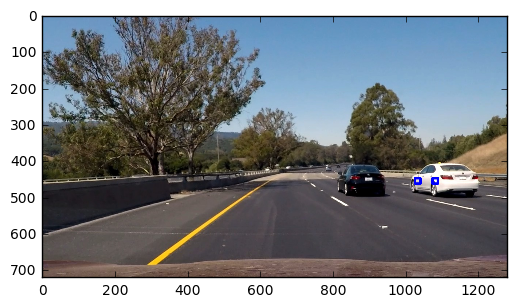

In [46]:
image = cv2.cvtColor(cv2.imread('./test_images/test6.jpg'), cv2.COLOR_BGR2RGB)

global heat
heat = np.zeros_like(image[:,:,0]).astype(np.float)

plt.imshow(process_image(image))

##### Project videos

In [ ]:
# get the saved classifier
svc_pickle = pickle.load(open( "svc_pickle.p", "rb" ))
svc = svc_pickle['svc']
X_scaler = svc_pickle['X_scaler']

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#process test video file
P5_output = './P5_test_video_out.mp4'
clip1 = VideoFileClip('./test_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(P5_output, audio=False)

[MoviePy] >>>> Building video ./P5_test_video_out.mp4
[MoviePy] Writing video ./P5_test_video_out.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 38/39 [01:09<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./P5_test_video_out.mp4 

Wall time: 1min 11s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(P5_output))

In [32]:
#process project video file
P5_output = './P5_project_video_out.mp4'
clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(P5_output, audio=False)

[MoviePy] >>>> Building video ./P5_project_video_out.mp4
[MoviePy] Writing video ./P5_project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [39:17<00:01,  1.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./P5_project_video_out.mp4 

Wall time: 39min 19s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(P5_output))